In [33]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox


import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap, HeatMapWithTime
import utm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from shapely.geometry import Point, LineString, Polygon
import folium

%matplotlib notebook
#%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__





C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'1.0.1'

In [34]:
def GPScoordinates_to_utm(lat,lon):
    """" Function that projects the GPS coordinates in degrees (latitude, longitude) into the UTM coordinate system
    in order to work with the concept of "point" and "Euclidean distance" in a plane.
    (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
    
    Note: We are dealing with locations in the same area/region. Otherwise, we should be careful if two locations 
    belong to different UTM zones when calculating distances, etc. 
    
    Input:
        - lists of GPS coordinates: latitude and longitude
        
    Output:
        - lists of the UTM projections of the GPS coordinates: 
        - The utm package returns Easting, Northing, Zone_number and Zone_letter. So we only store the two first elements
    """
    
    lat_utm=[]
    lon_utm=[]
    for i in range(len(lat)):
        u=utm.from_latlon(lat[i],lon[i])  # get the UTM projection
        lat_utm.append(u[0])   # Store the projection of latitude and longitude in lists
        lon_utm.append(u[1])
        
    return lat_utm, lon_utm
        
    

def EuclidianDistance(x1,y1,x2,y2):
    """ Function that returns the distance in metres between 2 points in a p(NO GPS locs.) 
    
    Note: Be careful as the GPS coordinates (lat,lon) cannot be used, but their projections to a plane (e.g. utm projection).

    
    Input:
        - The coordinates of two points in a plane: (x1,y1) and (x2,y2).
        
    Output:
        - Euclidian distance in metres between the two points.
    """
    Euclidian_distance = ( (x2-x1)**2 + (y2-y1)**2 ) ** 0.5
        
    return Euclidian_distance
        
    
        
def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)  # Diference between latitudes in radians
    dLon = radians(lon2-lon1) # Diference between longitudes in radians
    rLat1 = radians(lat1)   # Latitudes in radians
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 # Distance in m
   
    return e
   
    
    
def instantaneous_velocity(distance,time):
    """" Function that computes the instantenous velocity between two points, given their distance and their time difference.
    
    Input:
        - Distance between two points or two locations
        - Time difference between the two points/locations
        
    Output:
        - Instantenous velocity between the two points
    """
    
    v=distance/time
    
    return v


def convert(seconds):
    """" Function that converts the seconds to hours, minuts and seconds
    
    Input:
        - Number of seconds
        
    Output:
        - Hours, minuts and seconds
    """
    
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hour, minutes, seconds


def map_network(latitude, longitude, dist):
    """" Function that creates a map of the urban network in a given radius around a gps location.
    
    Input:
        - latitude and longitude (GPS coordinates)
        - dist: distance (radius) from which the network is constructed
        
    Output:
        - The figure and the axes.
        
    """
    
    G = ox.graph_from_point((latitude, longitude), dist, network_type='all')   # Create the graph from lat and lon
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def map_network2(lat1,lon1,lat2,lon2,lat3,lon3,lat4,lon4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates)
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lat1,lon1), (lat2,lon2),(lat3,lon3),(lat4,lon4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)
    place_name = "Granollers, Vallès Oriental"
    tags={"building": True}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf.shape
    gdf.plot(ax=ax,color='silver',alpha=0.5)
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area:
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def RadiusOfGyration(x,y):
    """" Function that computes the radius of gyration of a 2-d trajectory with x and y coordinates.
    
    M. C. Gonzalez, C. a C. A. Hidalgo, A. L. A.-L. Barabási, M. C. González, C. A. H. 
    & A.-L. B. Marta C. González, and M. C. Gonz, Nature 453, 779 (2008).
    
    Note: x,y coordinates can't be lat,lon in degrees. Before we must project them into a plane (e.g UTM projection)
    
    
    Input:
        - Lists of coordinates x and y
    
    Output:
        - Radius of gyration
    """
    
    r_cm_x=sum(x)/len(x)
    r_cm_y=sum(y)/len(y)
    
    radius2=[]
    for i in range(len(x)):
        r_new_x=x[i]-r_cm_x
        r_new_y=y[i]-r_cm_y
        radius2.append((r_new_x*r_new_x) + (r_new_y*r_new_y))
    
    mean_radius2=sum(radius2)/len(radius2)
    
    rg=mean_radius2**0.5
    
    return rg
        
    
        

            

def vector(latitude0,longitude0,latitude1,longitude1): 
    """ Given two points returns the vector from the origin point to destination. If GPS coordinates, use UTM projection.
    
    Input:
        - Coordinates of origin point (p0x,p0y) and destionation point (p1x, p1y).
    
    Oputput:
        - Coordinates of the vector from p0 to p1. 
    """
    
    p0=(latitude0,longitude0)   
    p1=(latitude1,longitude1)
    vec=(p1[0]-p0[0], p1[1]-p0[1]) 
    return vec


def determinant(vec0,vec1):
    """  Returns determinant of two vectors. If det<0 means that the second vector has turned in the clockwise direction.
    
    Input:
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
        
    Output:
        - Determinant of two vectors. If det<0 the second vector has turned in the clockwise direction respect to the first.
    """
    det=vec0[0]*vec1[1]-vec0[1]*vec1[0]
    return det

# Obtain the angle between two consecutive vectors (change in orientation, reorientation, turning angle).
# This angle is <0 if det<0 (clockwise) and >0 if counter clockwise
def reorientation(vec0,vec1):
    """Returns the angle between two consecutive vectors (change in orientation, reorientation, turning angle)
    The range is from -pi to +pi. If det<0 the second vector has turned in the clockwise direction and therefore the 
    reorientation angle is also <0. On contrary, if has turned counter-clockwise is >0. 
    
    Input: 
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
    
    Output:
        - Reorientation angle between them 
    """
    unit_vec0=vec0/np.linalg.norm(vec0)
    unit_vec1=vec1/np.linalg.norm(vec1)
    dot_product=np.dot(unit_vec0,unit_vec1)
    a=np.arccos(dot_product)
    det=determinant(vec0,vec1)
    if det<0:
        return -a
    else:
        return a

    
        
def turtuosity(latitudes,longitudes):
    """ Given the two lists of latitudes and longitudes (utm projection), it returns the turtuosity of the trajectory. 
    If turtuosity is near 0 means that the trajectory is very straight to the final destionation. If its near to 1 means that
    is the movement is very turtuous (not direct).
    
    Input:
        - Lists of x and y points (latitudes and longitudes projected) of a trajectory.
        
    Output:
        - Estimation of the turtuosity of the trajectory.
    """

    vectors=[]
    vectors_straight=[]
    for i in range(1,len(latitudes)):
        vectors.append(vector(latitudes[i-1],longitudes[i-1],latitudes[i],longitudes[i]))  # Vector between the point i-1 and  i.
        vectors_straight.append(vector(latitudes[i-1],longitudes[i-1],latitudes[-1],longitudes[-1]))  # straight vector between  
                                                                                         # point i and final point (destination)
        
    reorientations=[]   
    for i in range(len(vectors)-1):
        reorientations.append(np.cos(abs(reorientation(vectors_straight[i],vectors[i])))) # Reorientation angle 
        #reorientations2 = [x for x in reorientations if np.isnan(x) == False]  # avoid nan values                                                                           # vector and the straight vector (>=0)
            
    turtuo=1.-(sum(reorientations)/len(reorientations))  # The average value of the movement re-orientations gives the effiency
                                                         # of the trajectory (how straightforward/directed is towards the final
                                                         # destionation. Then 1 - effiency is the turtuosity
            
    return turtuo



def flights_stops(latitudes,longitudes,times,velocities,v_threshold):
    """ Given the velocities and the velocity threshold, it split the dataframe into 2 for flights and for stops 
    
    Input:
        - Lists of latitudes, longitudes, times, velocities
        - Velocity threshold for consider a point as a "stop"
        
    Output:
        - Two DataFrames for stops and flights with the information of latitude, longitude, time and velocity 
    """
    
    lat_flight=[]
    lon_flight=[]
    time_flight=[]
    v_flight=[]
    lat_stop=[]
    lon_stop=[]
    time_stop=[]  
    v_stop=[]
    for i in range(len(velocities)):
        if velocities[i]<=v_threshold:
            lat_stop.append(latitudes[i])
            lon_stop.append(longitudes[i])
            time_stop.append(times[i])
            v_stop.append(velocities[i])
            
        else:
            lat_flight.append(latitudes[i])
            lon_flight.append(longitudes[i])
            time_flight.append(times[i])
            v_flight.append(velocities[i])
            
    df_flights=pd.DataFrame()
    df_stops=pd.DataFrame()
    
    df_flights['lat']=lat_flight
    df_flights['lon']=lon_flight
    df_flights['time']=time_flight
    df_flights['v']=v_flight
    df_stops['lat']=lat_stop
    df_stops['lon']=lon_stop
    df_stops['time']=time_stop
    df_stops['v']=v_stop
    
    return df_flights, df_stops

    1- We read all the .gpx files in the folder
    2- We plot the trajectories in a map.
    3- We compute the total distance travelled, the amount of time spent, the mean instantenous velocity, the radious of gyration and the turtuosity.
    4- We create a HeatMap depending on the velocities.
    5- We create a HeatMap of the GPS positions
    6- We create a HeatMap of the GPS positions using Folium, with Zoom for a better visualisation.

# 1- Plot the trajectories on a Map using Folium

In [35]:
all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.
list_colors=['red','blue','green','yellow','purple']  # List of colors for each trajectory (each file)
j=0

m = Map(location=[41.603696311265445,2.282325874977035], zoom_start=30, tiles='OpenStreetMap')  # Create the Map of Granollers


for file in all_files:   # Loop over all gpx files in the folder/directory    
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    lat=df['lat'].tolist()  # Latitude and Longitude to lists
    lon=df['lon'].tolist()
    
    points=[]                     # Latitude and Longitude to tuple points:  [lat0, lon0], [lat1,lon1],...
    for ppp in range(len(lat)):
        points.append(tuple([lat[ppp],lon[ppp]]))
        
    # Add the GPS locs (trajectories) to the map
    folium.PolyLine(points,popup=file,tooltip=file,color=list_colors[j],weight=2).add_to(m)   
    
    j=j+1
        
m  

#m.save("granollers_folium.html")  # Save the map to a html file

# 2- HeatMap of the GPS locations using Folium

In [36]:
all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.

m = Map(location=[41.603696311265445,2.282325874977035], zoom_start=30,tiles='OpenStreetMap')  # Create the Map of Granollers

lat_tots=[]
lon_tots=[]
for file in all_files:   # Loop over all gpx files in the folder/directory    
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    lat=df['lat'].tolist()  # Latitude and Longitude to lists
    lon=df['lon'].tolist()
    
    lat_tots.extend(lat)   # Store all the latitudes and longitudes
    lon_tots.extend(lon)


hm_wide = HeatMap(                      # Create the HeatMap
    list(zip(lat_tots, lon_tots)),
    min_opacity=0.2,
    radius=15, 
    blur=10, 
    max_zoom=1,
)

m.add_child(hm_wide)

#m.save("granollers_folium_heatmap.html")  # Save the map to a html file

# 3- HeatMap of the GPS locations depending on the velocity using Folium

In [37]:
all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.

m = Map(location=[41.603696311265445,2.282325874977035], zoom_start=30, tiles='OpenStreetMap')  # Create the Map of Granollers

lat_tots=[]
lon_tots=[]
velocity_all=[]
for file in all_files:   # Loop over all gpx files in the folder/directory    
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')  # Correct format for the time (datetime)
    lat=df['lat'].tolist()  # Latitude and Longitude to lists
    lon=df['lon'].tolist()
    temps=df['time'].tolist()
    
    
    lat_tots.extend(lat)   # Store all the latitudes and longitudes
    lon_tots.extend(lon)


    # TIME DIFFERENCE.
    diff_time=[]
    for i in range(1,len(df['time'])):
        diff=temps[i]-temps[i-1]
        diff_time.append(diff)
        
    diff_time.insert(len(diff_time), np.nan)  # Obviuosly, if there are N times, there will be N-1 times differences.
    df['At']=diff_time   # Store it as a new column in the data frame and transform the difference into total seconds.
    df['At']=df['At'].dt.seconds
    t=df['At'][:-1].tolist()  # Time difference (AT) in seconds into list (disregarding the last element, NaN)
        
        
    # DISTANCE.
    distance=[]
    for p in range(1,len(lat)):
        dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])   # Distance in metres between every GPS location.
        distance.append(dist)        

        
    # INSTANTANEOUS VELOCITY.
    velocity=[]
    for k in range(len(distance)):
        velocity.append(instantaneous_velocity(distance[k],t[k]))   # Instantenous velocity every consecutive GPS locs.
    
    velocity.insert(len(velocity), 0.0)  # Add 0.0 value in the last position (to have equal lenght lists)
    velocity_all.extend(velocity)  # Store all the velocities (all trajectories)
    
    
    
hm_wide = HeatMap(                      # Create the HeatMap adding the weights (velocities)
    list(zip(lat_tots, lon_tots, velocity_all)),
    min_opacity=0.2,
    radius=15, 
    blur=10, 
    max_zoom=1,
)

m.add_child(hm_wide)

#m.save("granollers_folium_heatmap_velocities.html")  # Save the map to a html file

# 4- HeatMap with time using Folium

In [38]:
all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.

m = Map(location=[41.603696311265445,2.282325874977035], zoom_start=30, tiles='OpenStreetMap')  # Create the Map of Granollers

lat_tots=[]
lon_tots=[]
time_tots=[]
for file in all_files:   # Loop over all gpx files in the folder/directory    
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    lat=df['lat'].tolist()  # Latitude and Longitude to lists
    lon=df['lon'].tolist()
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')  # Correct format for the time (datetime)

    time=df['time'].tolist()

    
    lat_tots.extend(lat)   # Store all the latitudes and longitudes
    lon_tots.extend(lon)
    time_tots.extend(time)
    
    
dff=pd.DataFrame()    # DataFrame with all the data (latitude, longitude and time). All trajectories
dff['lat']=lat_tots
dff['lon']=lon_tots
dff['time']=time_tots


dff['time'] = dff['time'].sort_values(ascending=True)     # Group de Data by frequency (1 Min or whatever we want)
data = []
for _, d in dff.groupby(pd.Grouper(key='time', axis=0, 
                      freq='2Min')):
    data.append([[row['lat'], row['lon']] for _, row in d.iterrows()])


hm_wide = HeatMapWithTime(                      # Create the HeatMap With Time.
    data,
    min_opacity=0.2,
    radius=10
)

m.add_child(hm_wide)

#m.save("granollers_folium_heatmap_time.html")  # Save the map to a html file

# 5- OSMNX (OpenStreetMaps Networks) and STATISTICS

### 5.1- Statistics: duration, total distance, mean velocity, turtuosity, radious of giration
### 5.2- Osmnx:  Map of trajectories (points)
### 5.3 Osmnx:  HeatMap of positions
### 5.4- Osmnx:  HeatMap of positions depending on their velocity value


<IPython.core.display.Javascript object>


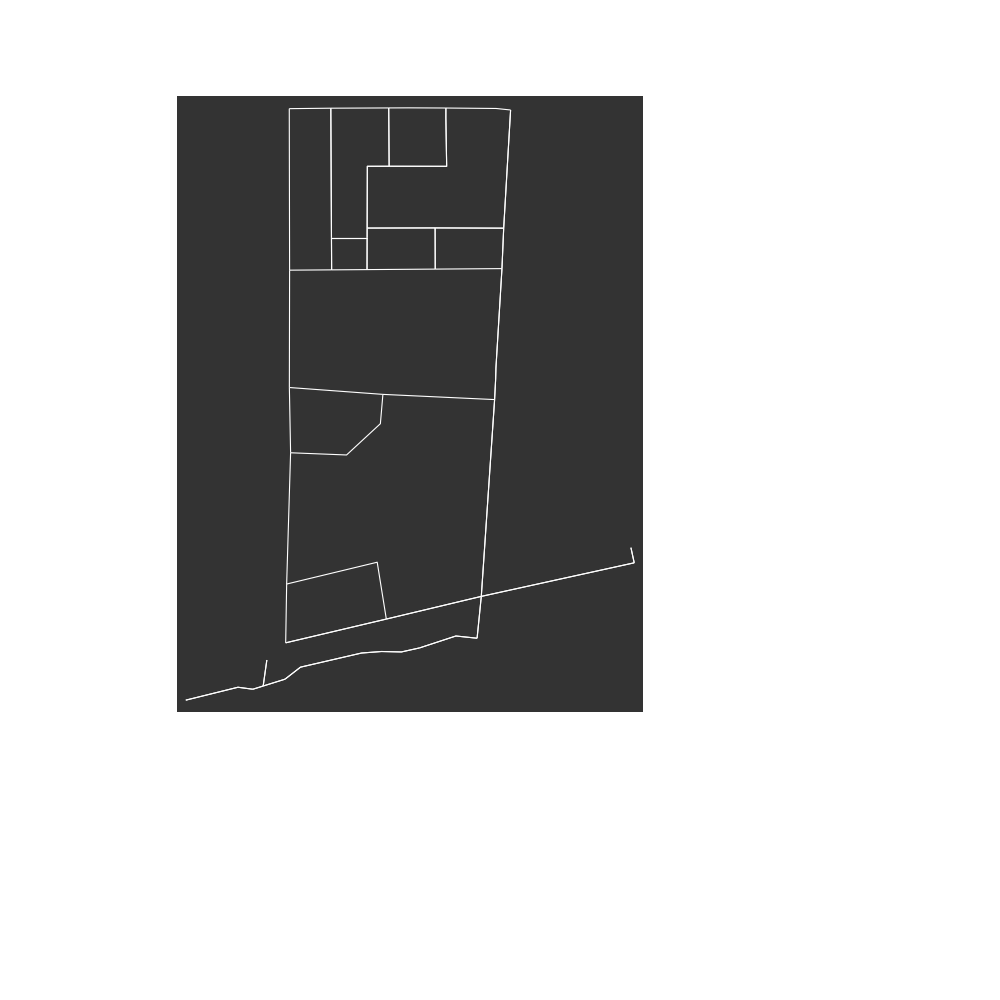

Grup: Granollers.gpx

La durada total del trajecte és de: 0.0 hores  5.0 minuts  i  25.0 segons

La distància total recorreguda és de: 389.147336313088 metres

La velocitat mitjana és de: 1.4295705935274488 m/s  std: 0.3302851656732202 m/s
La velocitat mitjana és de: 5.146454136698815 km/h  std: 1.1890265964235927 km/h

El radi de gir és de: 79.71843982695175 m

La turtuositat és de: 0.524012617794621

-------------------------------------------
Grup: Granollers2.gpx

La durada total del trajecte és de: 0.0 hores  3.0 minuts  i  49.0 segons

La distància total recorreguda és de: 286.430533789956 metres

La velocitat mitjana és de: 1.3041014981053582 m/s  std: 0.2633265835808934 m/s
La velocitat mitjana és de: 4.694765393179289 km/h  std: 0.9479757008912162 km/h

El radi de gir és de: 31.729874903698743 m

La turtuositat és de: 0.7889946522032689

-------------------------------------------
Grup: Granollers3.gpx

La durada total del trajecte és de: 0.0 hores  6.0 minuts  i  7.0 segons



<IPython.core.display.Javascript object>


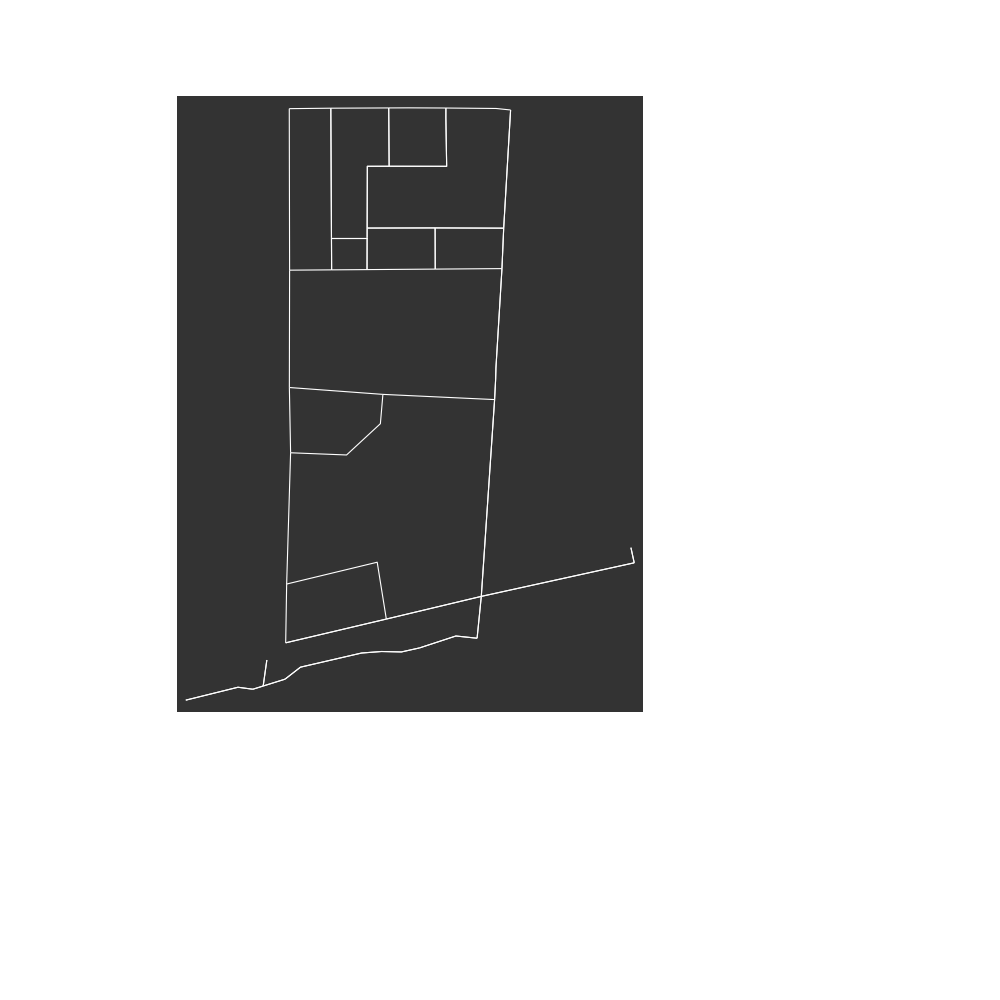



HEATMAP GPS POSITIONS


<IPython.core.display.Javascript object>


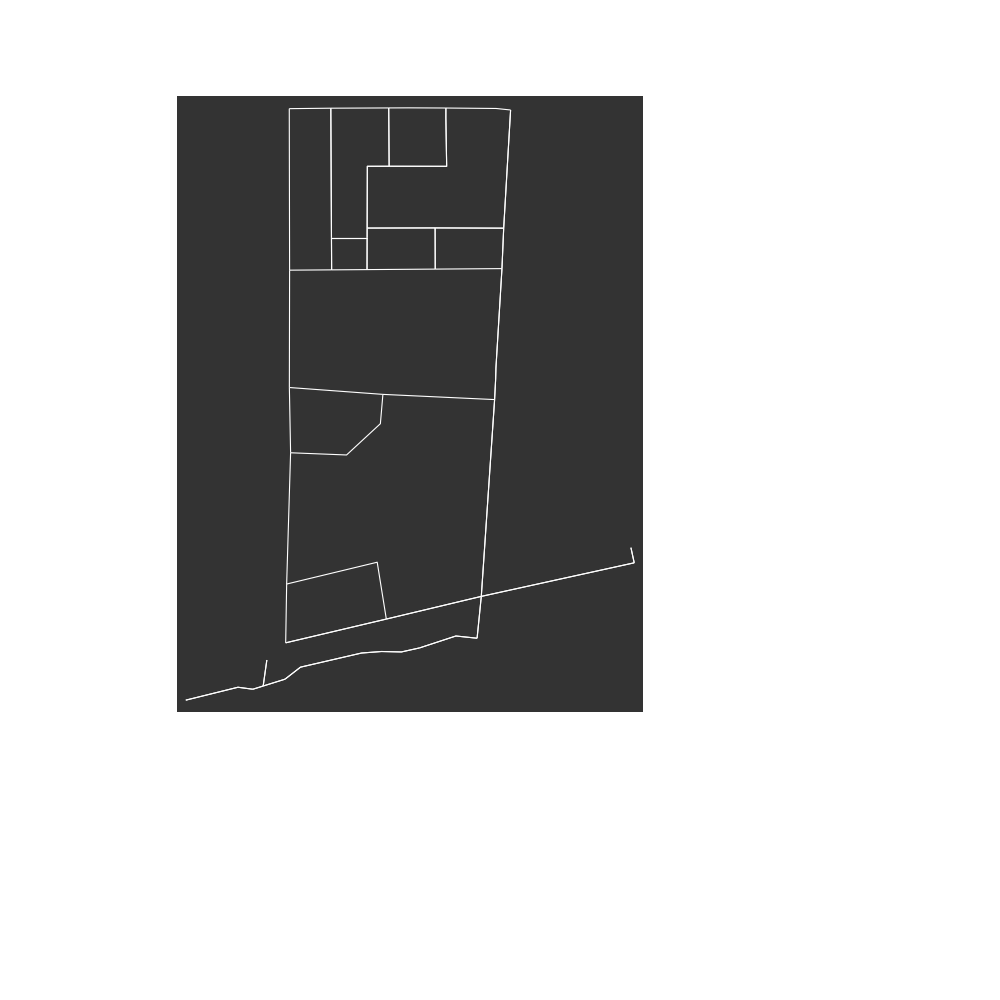

In [39]:
fig, ax = map_network2(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)  # Create the graph from a given latitude and longitude

all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.


list_colors=['red','blue','green','yellow','purple']  # List of colors for each trajectory (each file)
j=0

latitud_tots=[]  # Initialise list for all the latitudes and longitudes
longitud_tots=[]
velocity_all=[]
time=[]

for_map2 = Map(location=[41.603696311265445,2.282325874977035], zoom_start=15, tiles='cartodbpositron')

for file in all_files:   # Loop over all gpx files in the folder/directory  
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    print('Grup:', file)
    print('')
    
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')  # Correct format for the time (datetime)
    
    temps=df['time'].tolist()
    
    lat=df['lat'].tolist()  # Time, Latitude and Longitude to lists
    lon=df['lon'].tolist()
    
    points=[]
    for ppp in range(len(lat)):
        points.append(tuple([lat[ppp],lon[ppp]]))
        
    f1=folium.FeatureGroup(file)
    line_1=folium.vector_layers.PolyLine(points,popup='<b>Path of Vehicle_1</b>',tooltip=file,color=list_colors[j],weight=1).add_to(f1)
    f1.add_to(for_map2)
    folium.LayerControl().add_to(for_map2)
    
    
        
    lat_utm, lon_utm=GPScoordinates_to_utm(lat,lon)  # UTM projections of the Latitude and Longitud lists
    
    latitud_tots.extend(lat)  # Store the latitude and longitude lists for each gile in a common list
    longitud_tots.extend(lon)
    time.extend(temps)
    t = np.linspace(0, len(lat)-1, len(lat))  # For the HeatMap


    
    # Plot the coordinates of each trajectory in the street network, with a given color.
    ax.scatter(lon, lat,c=list_colors[j],s=5) # Scatter the GPS locs. with a given color from the list of colors
    ax.scatter(lon[0], lat[0], marker='s', c=list_colors[j],s=300) # Scatter the starting point with a big a square
    ax.scatter(lon[-1], lat[-1], marker='*', c=list_colors[j],s=300) # Scatter the last point with a big star

    j=j+1
    
    
    #STATISTICS. Now we obtain the time difference, the distance and the instantenous velocity between each Geo-location.
    # The calculation is made "in advance". That is, the time difference at the point "i" is  AT(i)=t(i+1)-t(i). So the AT
    # at point N does not exist (considering N points in the trajectory).
        
    
    
    # TIME DIFFERENCE.
    diff_time=[]
    for i in range(1,len(df['time'])):
        diff=temps[i]-temps[i-1]
        diff_time.append(diff)
    
     # Obviuosly, if there are N times, there will be N-1 times differences. So we need to add a NaN value at the end of 
     # the list to store it as a new column of the DataFrame. 
    
    diff_time.insert(len(diff_time), np.nan)  # Obviuosly, if there are N times, there will be N-1 times differences.
    
    df['At']=diff_time   # Store it as a new column in the data frame and transform the difference into total seconds.
    df['At']=df['At'].dt.seconds
    
    t=df['At'][:-1].tolist()  # Time difference (AT) in seconds into list (disregarding the last element, NaN)
    total_seconds_trajectory=sum(t)
    hours, minutes, seconds=convert(total_seconds_trajectory)
    print('La durada total del trajecte és de:', hours, 'hores','', minutes,'minuts','','i','', seconds, 'segons')
    print('')
    
    
    # DISTANCE.
    distance=[]
    for p in range(1,len(lat)):
        dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])
        distance.append(dist)        
    print('La distància total recorreguda és de:', sum(distance), 'metres')
    print('')
    
    
    # INSTANTANEOUS VELOCITY.
    velocity=[]
    for k in range(len(distance)):
        velocity.append(instantaneous_velocity(distance[k],t[k]))
    
    mean = sum(velocity) / len(velocity)
    variance = sum([((x - mean) ** 2) for x in velocity]) / len(velocity)
    res = variance ** 0.5
    print('La velocitat mitjana és de:', mean, 'm/s', '', 'std:',res, 'm/s')
    print('La velocitat mitjana és de:', 3.6*mean,'km/h','', 'std:',3.6*res ,'km/h')
    print('') 
    velocity.insert(len(velocity), np.nan) 
    velocity_all.extend(velocity)

    # RADIUS OF GYRATION.   
    Rg=RadiusOfGyration(lat_utm, lon_utm)
    print('El radi de gir és de:', Rg, 'm')
    print('')
    
    # TURTUOSITY
    turto=turtuosity(lat_utm,lon_utm)
    print('La turtuositat és de:', turto)
    print('')
    print('-------------------------------------------')
    

plt.show()

for_map2.save("granollers.html")

# HEATMAP WITH OSMNX USING VELOCITIES.
print('HEATMAP DEPENDING ON VELOCITIES')

fig, ax = map_network2(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)

df_tots = pd.DataFrame(            
    {'velocitats': velocity_all,
     'latitud': latitud_tots,
     'longitud': longitud_tots,
     'temps':time
    })


df_tots2=df_tots.copy()
df_tots2=df_tots2.drop(df_tots2[ (df_tots2['velocitats'] > 7) ].index)


v=df_tots2['velocitats'].tolist()
lat=df_tots2['latitud'].tolist()
lon=df_tots2['longitud'].tolist()
sss=ax.scatter(lon, lat, c=v, cmap='jet',s=20)
fig.colorbar(sss, ax=ax)
#ax.set_title('SGV')
plt.show()

print('')
print('')


# HEATMAP WITH OSMNX USING POSITIONS.
print('HEATMAP GPS POSITIONS')
fig, ax = map_network2(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)
# Calculate the point density
xy = np.vstack([lat,lon])
z = gaussian_kde(xy)(xy)

sss=ax.scatter(lon, lat, c=z, cmap='jet',s=20)
fig.colorbar(sss, ax=ax)



plt.show()

print('')
print('')




    

# 6- Animation of trajectories using OSMNX

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


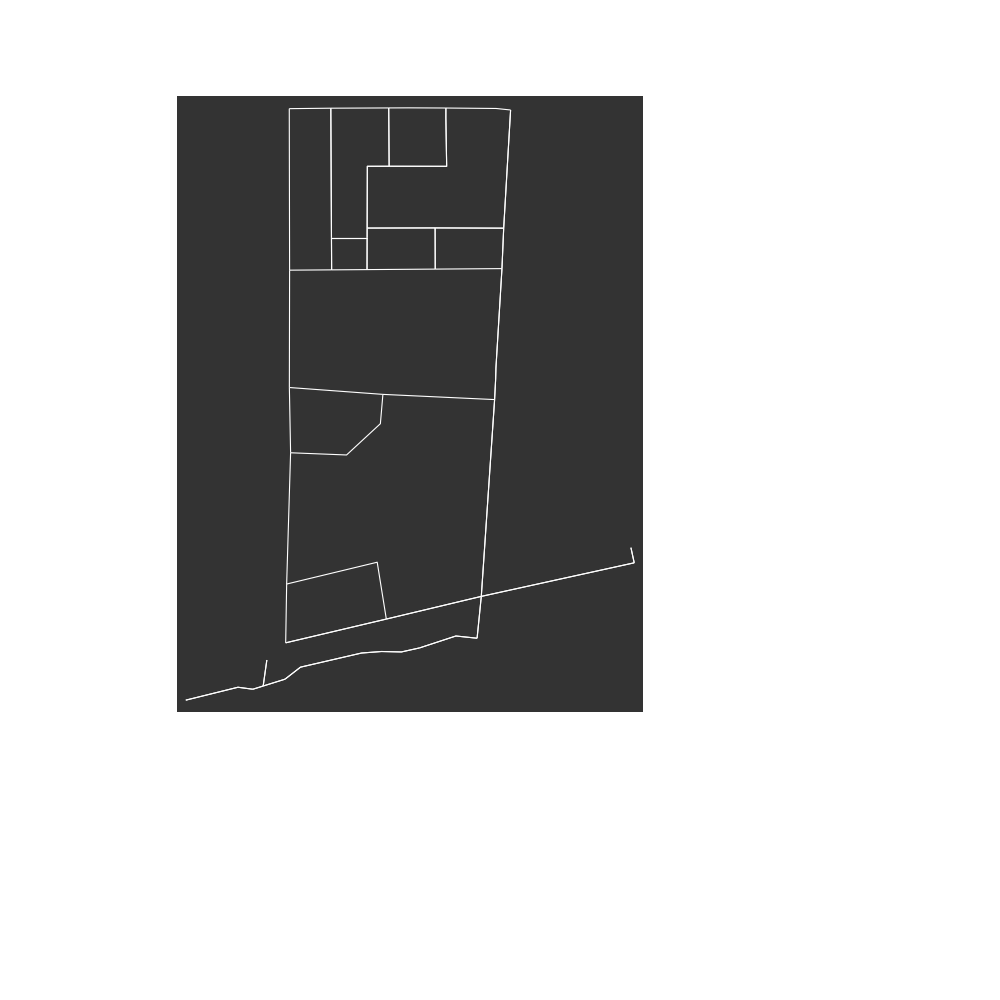

In [50]:
# import required modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 

def updateline(num, data, line1, data2, line2, data3,line3):
    line1.set_data(data[..., :num])
    line2.set_data(data2[..., :num])
    line3.set_data(data3[..., :num])
     
    #time_text.set_text("Points: %.0f" % int(num))
     
    return line1, line2, line3
 
 
# generating data of 100 elements
df1 = pd.DataFrame(gpxtolist('Granollers.gpx'))
df2 = pd.DataFrame(gpxtolist('Granollers2.gpx'))    # each individual trajectory (.gpx file)
df3 = pd.DataFrame(gpxtolist('Granollers3.gpx'))

lat1=df1['lat'].values
lon1=df1['lon'].values
lat2=df2['lat'].values
lon2=df2['lon'].values
lat3=df3['lat'].values
lon3=df3['lon'].values

data=np.array([lon1,lat1])
data2=np.array([lon2,lat2])  
data3=np.array([lon3,lat3])

 
# setup the formating for moving files
Writer = animation.writers['ffmpeg']
Writer = Writer(fps=10, metadata=dict(artist="Me"), bitrate=-1)
 

fig,ax= map_network2(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)  # initialise the map
#fig = plt.figure()
#plt.axes(xlim=(41.602602, 41.604791), ylim=(2.281307,2.283078))


l,=ax.plot([], [], '-',c='red',linewidth=2)
k,=ax.plot([], [], '-',c='blue',linewidth=2)
m,=ax.plot([], [], '-',c='green',linewidth=2)

#time_text = ax.text(0.1, 0.95, "", transform=ax.transAxes,
                    #fontsize=15, color='red')
 
# set line_animation variable to call
# the function recursively
anim = animation.FuncAnimation(fig, updateline, frames=100, fargs=(data, l, data2, k,data3,m))
anim.save("trajectories_granollers.mp4", writer=Writer)

# 7- STOPS

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


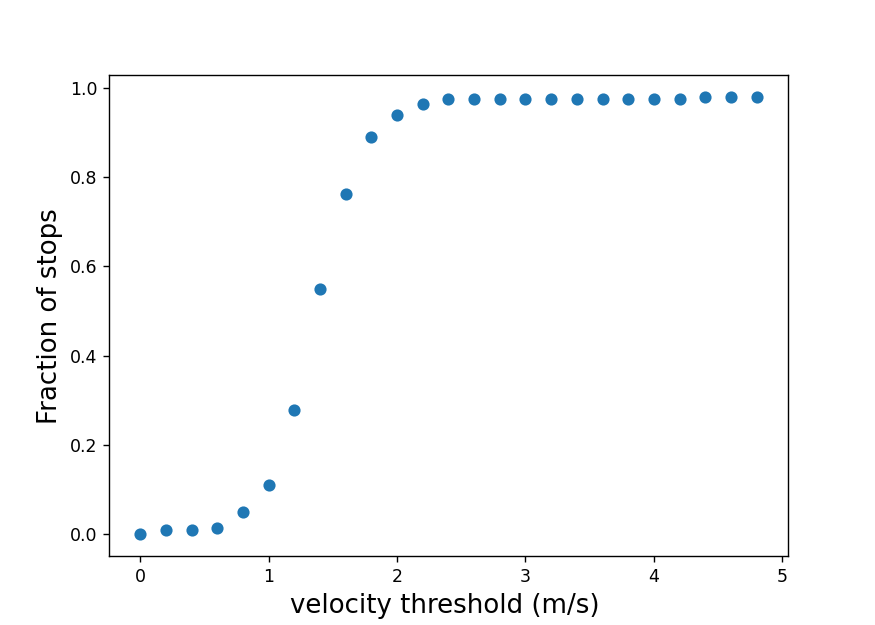

In [51]:
from scipy.interpolate import UnivariateSpline
llindar_v = np.arange(0.0,5.0,0.2)  # vector with velocity thresholds:  0.2, 0.4, 0.6, 0.8....5  m/s

# For each velocity threshold, we count how many velocities (using all data) are less or equal than the threshold.
# So if v <= v_threshold we consider that at that point the user is stopped. And count how many stops are in the data (fraction)
stops=[]          
for i in llindar_v:    
    stop=0
    for j in range(len(df_tots)):
        if df_tots['velocitats'][j]<=i:
            stop=stop+1
    stops.append(stop/len(df_tots))
         

fig, ax = plt.subplots(figsize=(7,5))    # plot the fraction of stops there are in the data as a function of the threshold.
ax.scatter(llindar_v,stops)
ax.set_xlabel('velocity threshold (m/s) ', fontsize=15)
ax.set_ylabel('Fraction of stops',fontsize=15)   

plt.show()

<IPython.core.display.Javascript object>


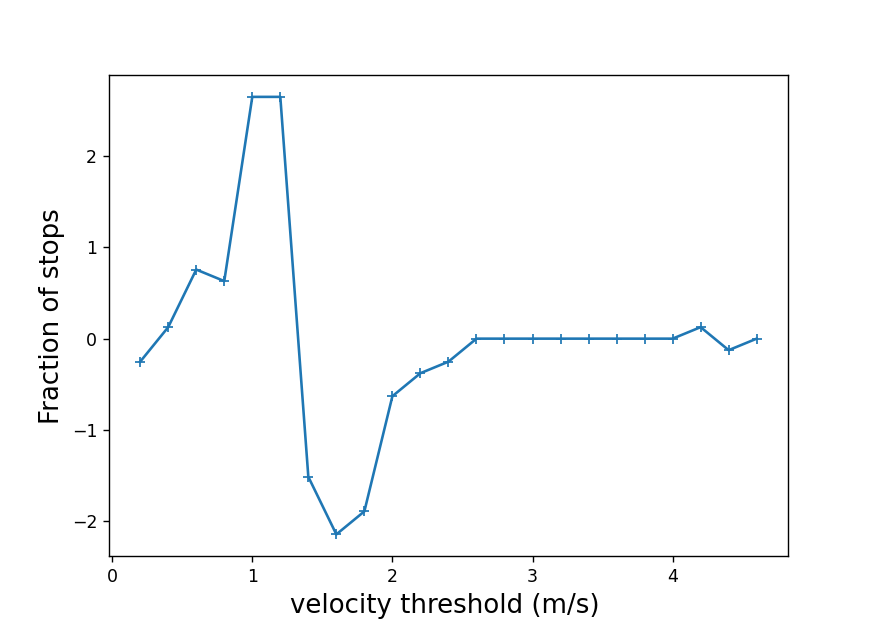

In [52]:
stopsn=np.array(stops)

dy=np.diff(stops,1)
dx=np.diff(llindar_v,1)
yfirst=dy/dx


xfirst=0.5*(llindar_v[:-1]+llindar_v[1:])

dyfirst=np.diff(yfirst,1)
dxfirst=np.diff(xfirst,1)
ysecond=dyfirst/dxfirst

xsecond=0.5*(xfirst[:-1]+xfirst[1:])

fig, ax = plt.subplots(figsize=(7,5))    # plot the fraction of stops there are in the data as a function of the threshold.
ax.plot(xsecond,ysecond,'+-')
ax.set_xlabel('velocity threshold (m/s) ', fontsize=15)
ax.set_ylabel('Fraction of stops',fontsize=15)

plt.show()

In [53]:
print(ysecond)
print(xsecond)

[-0.25252525  0.12626263  0.75757576  0.63131313  2.65151515  2.65151515
 -1.51515152 -2.14646465 -1.89393939 -0.63131313 -0.37878788 -0.25252525
  0.          0.          0.          0.          0.          0.
  0.          0.          0.12626263 -0.12626263  0.        ]
[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6
 3.8 4.  4.2 4.4 4.6]


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
print(ysecond[5],ysecond[6])

print(xsecond[5],xsecond[6])

m= ((ysecond[6]-ysecond[5])/(xsecond[6]-xsecond[5]))
v_threshold=(m*xsecond[6]-ysecond[6])/m
print(v_threshold)

2.6515151515151527 -1.5151515151515158
1.2000000000000002 1.4000000000000001
1.3272727272727274


In [55]:
latitudes=df_tots['latitud']
longitudes=df_tots['longitud']
times=df_tots['temps']
velocities=df_tots['velocitats']

In [56]:

df_flights,df_stops=flights_stops(latitudes,longitudes,times,velocities,v_threshold)

In [57]:
df_flights

,lat,lon,time,v
0,41.602765,2.282707,2022-02-23 18:34:15+00:00,1.673671
1,41.602857,2.282719,2022-02-23 18:34:22+00:00,1.669995
2,41.602972,2.282658,2022-02-23 18:34:38+00:00,1.538714
3,41.602990,2.282588,2022-02-23 18:34:42+00:00,1.683068
4,41.602997,2.282528,2022-02-23 18:34:45+00:00,1.670919
...,...,...,...,...
105,41.602922,2.282771,2022-02-23 18:48:23+00:00,1.397605
106,41.602851,2.282738,2022-02-23 18:48:34+00:00,1.414029
107,41.602866,2.282673,2022-02-23 18:48:38+00:00,1.513090
108,41.602904,2.282342,2022-02-23 18:49:01+00:00,1.573693


In [58]:
df_stops

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lat,lon,time,v
0,41.602712,2.282685,2022-02-23 18:34:10+00:00,1.234140
1,41.602810,2.282712,2022-02-23 18:34:18+00:00,1.314618
2,41.602902,2.282722,2022-02-23 18:34:25+00:00,0.983101
3,41.602955,2.282725,2022-02-23 18:34:31+00:00,0.840409
4,41.603060,2.282355,2022-02-23 18:34:56+00:00,1.192330
...,...,...,...,...
83,41.602841,2.282007,2022-02-23 18:49:25+00:00,1.230973
84,41.602823,2.281937,2022-02-23 18:49:30+00:00,1.164068
85,41.602823,2.281867,2022-02-23 18:49:35+00:00,1.275447
86,41.602811,2.281792,2022-02-23 18:49:40+00:00,1.042072


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


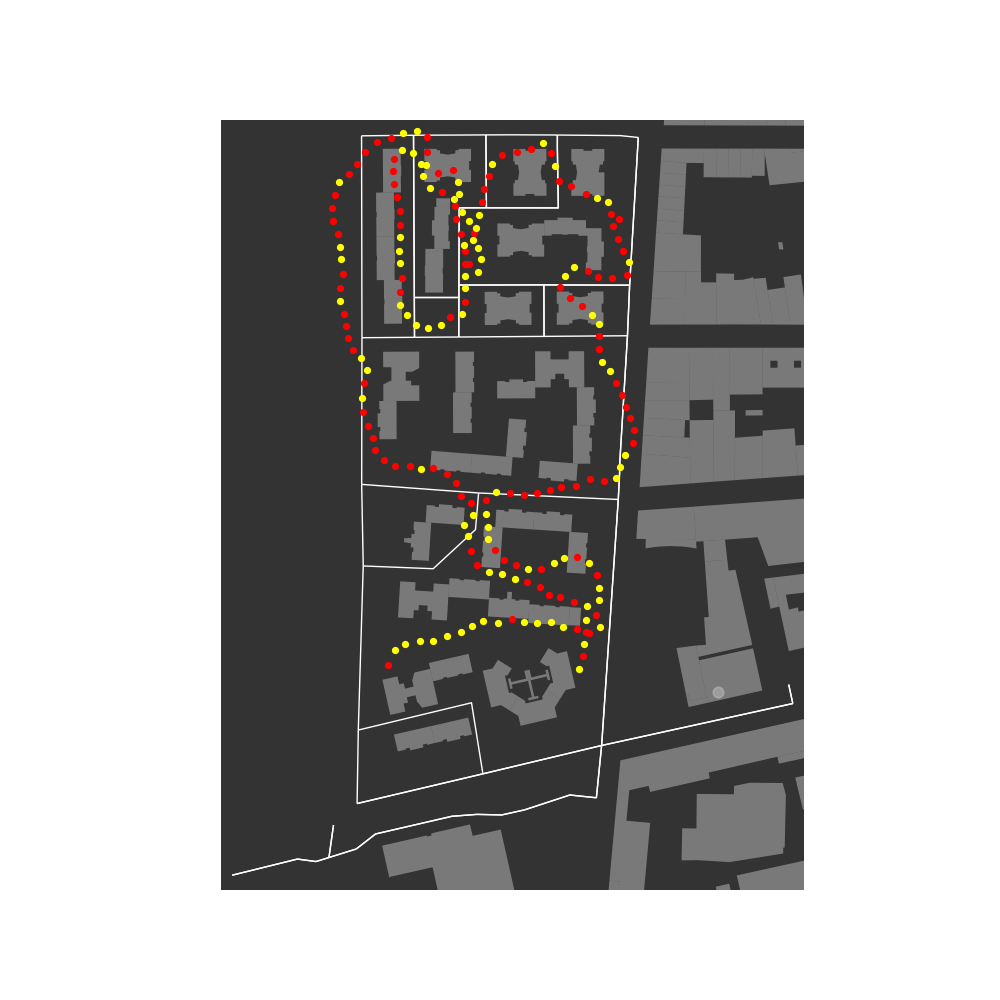

In [59]:
fig, ax = map_network2(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)  # Create the graph from a given latitude and longitude

list_colors=['red','yellow']  # List of colors for each trajectory (each file)
j=0

lat_flights=df_flights['lat'].tolist()
lon_flights=df_flights['lon'].tolist()
lat_stops=df_stops['lat'].tolist()
lon_stops=df_stops['lon'].tolist()


# Plot the coordinates of each trajectory in the street network, with a given color.
ax.scatter(lon_flights, lat_flights,c='red',s=10) # Scatter the GPS locs. with a given color from the list of colors
ax.scatter(lon_stops, lat_stops,c='yellow',s=10)

plt.show()
